In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(scran)
    library(survival)
    library(survminer)
})

In [2]:
sce <- readRDS("../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_analysed.rds")

In [3]:
ZScore <- function(x){
   return((x - mean(x)) / sd(x))
 }
id_map <- read.table("/raid1/heyao/project/scHCC-tumor/data/TCGA_survival_data/gencode_v22_gene_annotation_table.txt", header=T)
rownames(id_map) <- id_map$ENSEMBL
freq <- as.data.frame(table(id_map$SYMBOL))
id_map <- id_map[!(id_map$SYMBOL %in% as.vector(freq[freq$Freq>1,]$Var1)),] ## remove genes with more than one Gene ID
DoSurvivalPlot <- function(cancer = "LIHC", gene.list, normalize.by.gene = NULL, 
                           low.quantile = 0.5, high.quantile = 0.5, column.used = c("gender", "stage", "age"), 
                           
                           survival.used = "PFI", signature.name = "GeneSet"){
   ## Do the gene survival plot.
   ##
   ## Args:
   #'  @surv_dataset: cancer type.
   #'  @gene.list: One gene or a gene set.
   #'  @normalize.by.gene: Use which gene to normalize data, can only be one single gene.
   #'  @low.quantile: The expression of samples lower than low.quantile will be used as the low expression group.
   #'  @high.quantile: The expression of samples higher than high.quantile will be used as the high expression group.
   #'  @survival.used: "OS" or "PFI".
   #'  @signature.name: A character of signature in legend.
   ##
   ## Returns:
   ##  A survival km-curve plot and coxph test result.

   survival_dataset <- readRDS(paste0("/raid1/heyao/project/scHCC-tumor/data/TCGA_survival_data/",cancer,".rds"))
   gene.list <- toupper(gene.list)


   expression_dataset <- as.data.frame(survival_dataset$expression)
   clinical_dataset <- survival_dataset$clinical
   clinical_dataset$OS <- clinical_dataset$OS + 1     ## 1 for censored and 2 for death
   clinical_dataset$DSS <- clinical_dataset$DSS + 1
   clinical_dataset$DFI <- clinical_dataset$DFI + 1
   clinical_dataset$PFI <- clinical_dataset$PFI + 1
   print("Here")
   if(sum(column.used == 'stage')){
   clinical_dataset$stage[which(clinical_dataset$stage %in% c("Stage 0"))] <- 0
   clinical_dataset$stage[which(clinical_dataset$stage %in% c("Stage I", "Stage IA","Stage IB"))] <- 1
   clinical_dataset$stage[which(clinical_dataset$stage %in% c("Stage II", "Stage IIA", "Stage IIB", "Stage IIC"))] <- 2
   clinical_dataset$stage[which(clinical_dataset$stage %in% c("Stage III", "Stage IIIA", "Stage IIIB", "Stage IIIC"))] <- 3
   clinical_dataset$stage[which(clinical_dataset$stage %in% c("Stage IV", "Stage IVA", "Stage IVB","Stage IVC"))] <- 4
   clinical_dataset <- clinical_dataset[which(clinical_dataset$stage %in% c(0,1,2,3,4)),]
   clinical_dataset$stage <- factor(clinical_dataset$stage)
   }
   ## the gene id to gene name
   gene_id_used <- intersect(rownames(expression_dataset),id_map$ENSEMBL)
   expression_dataset <- expression_dataset[gene_id_used,]
   rownames(expression_dataset) <- id_map[gene_id_used,]$SYMBOL
   
   gene_used <- intersect(gene.list, row.names(expression_dataset))
   sample_used <- intersect(colnames(expression_dataset), row.names(clinical_dataset))
   
   clinical_dataset_used <- clinical_dataset[sample_used, c(paste0(survival.used,".time"), survival.used, column.used)]
   clinical_dataset_used <- clinical_dataset_used[rowSums(is.na(clinical_dataset_used)) == 0 & rowSums(clinical_dataset_used == "") == 0,] ## remove NA and blank element
   sample_used <- row.names(clinical_dataset_used)
   
   expression_dataset_zscore <- t(apply(expression_dataset[gene_used, sample_used], 1, ZScore)) ## z-transform each genes
   expression_dataset_zscore_mean <- apply(expression_dataset_zscore, 2, mean) ## average the expression of geneset
   if(!is.null(normalize.by.gene)){
          normalize.by.gene <- toupper(normalize.by.gene)
     expression_dataset_zscore_mean <- expression_dataset_zscore_mean - as.vector(apply(expression_dataset[normalize.by.gene,sample_used], 1, ZScore))
   }
   expression_dataset_zscore_mean_cutoff <- quantile(expression_dataset_zscore_mean, probs = c(low.quantile, high.quantile))
   
   expression_dataset_high_samples <- names(expression_dataset_zscore_mean)[expression_dataset_zscore_mean >= expression_dataset_zscore_mean_cutoff[2]]
   expression_dataset_low_samples <- names(expression_dataset_zscore_mean)[expression_dataset_zscore_mean < expression_dataset_zscore_mean_cutoff[1]]
   clinical_dataset_used <- clinical_dataset_used[c(expression_dataset_high_samples, expression_dataset_low_samples),]
   clinical_dataset_used$group <- "high"
   clinical_dataset_used[expression_dataset_low_samples,"group"] <- "low"
   clinical_dataset_used$group <- factor(clinical_dataset_used$group, levels = c("low", "high"))
   cat("The number of samples used in",cancer,"is", nrow(clinical_dataset_used),"\n")
	cat("The number of samples used in",cancer,"is (high):", nrow(clinical_dataset_used[clinical_dataset_used$group == 'high',]),"\n")
	cat("The number of samples used in",cancer,"is (low):", nrow(clinical_dataset_used[clinical_dataset_used$group == 'low',]),"\n")
	
   surv_clinical_obj <- Surv(clinical_dataset_used[,paste0(survival.used,".time")], clinical_dataset_used[,survival.used])
   cox_formula <- as.formula(paste0("surv_clinical_obj ~ group + ", paste0(column.used, collapse = " + ")))
   cox_clinical_used <- coxph(cox_formula, data = clinical_dataset_used)

   # Must use do.call or there will be something wrong with ggsurvplot which warns that no data
   fit <- do.call(survfit, list( formula = surv_clinical_obj ~ group, data = clinical_dataset_used)) 

   survplot <- ggsurvplot(fit,
                         legend.title = signature.name,
                         font.legend = 16,
                         legend = "right",
						 risk.table = TRUE,
                         pval = paste0("P = ", round(summary(cox_clinical_used)$coefficients[1,5],2), "\nHR = ", round(summary(cox_clinical_used)$coefficients[1,2],2)),
                         palette = c("group=high" = "#E41A1C", "group=low" = "#377EB8")
   )
   return(list(survplot = survplot,expr_matrix = expression_dataset_zscore, 
               cox_result = cox_clinical_used))   
 }

In [33]:
res <- DoSurvivalPlot(cancer = "LIHC", gene.list = 'TIMP1', low.quantile = 0.2, high.quantile = 0.8, column.used = c('gender','age'), 
                    survival.used = "OS", signature.name = "GeneSet")

[1] "Here"
The number of samples used in LIHC is 148 
The number of samples used in LIHC is (high): 74 
The number of samples used in LIHC is (low): 74 


In [35]:
aa <- res$expr_matrix

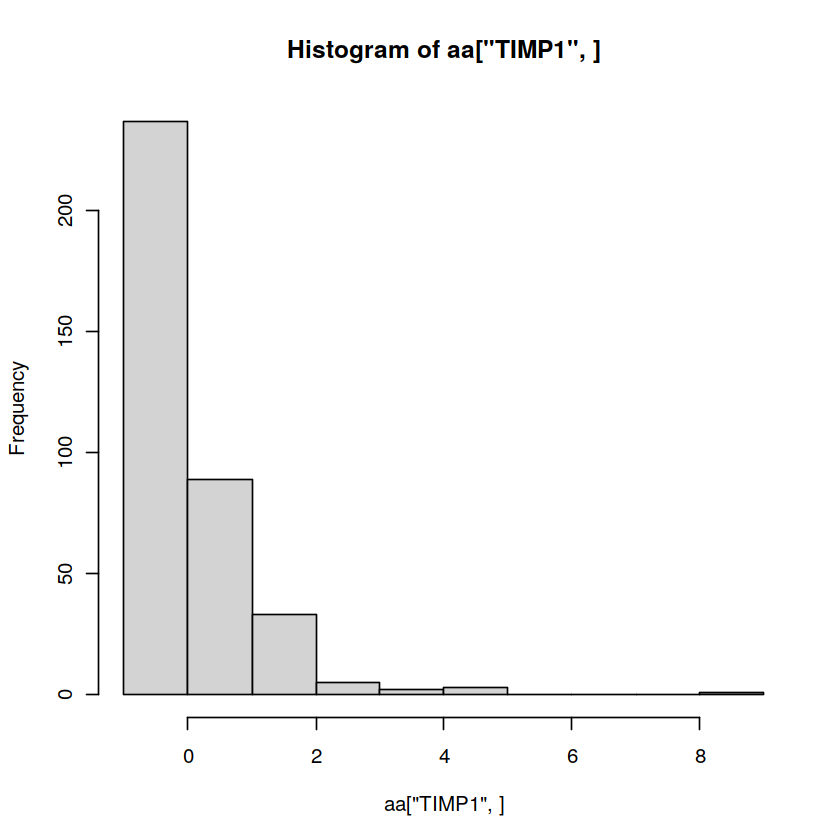

In [37]:
hist(aa['TIMP1',])

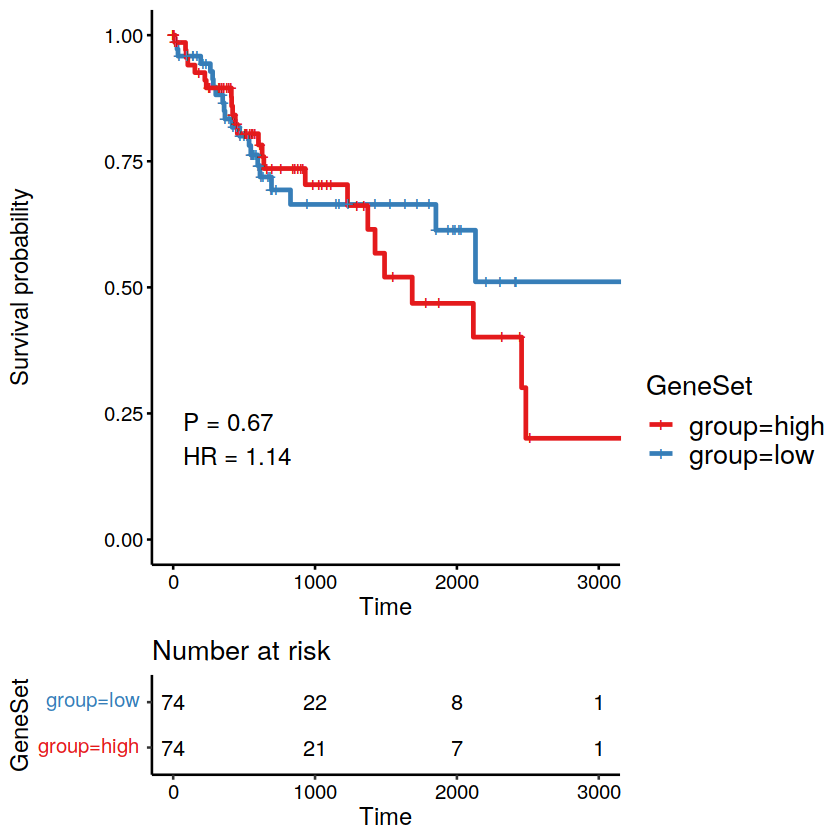

In [34]:
res$survplot